In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from planck_util import PlanckSpectrumT

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


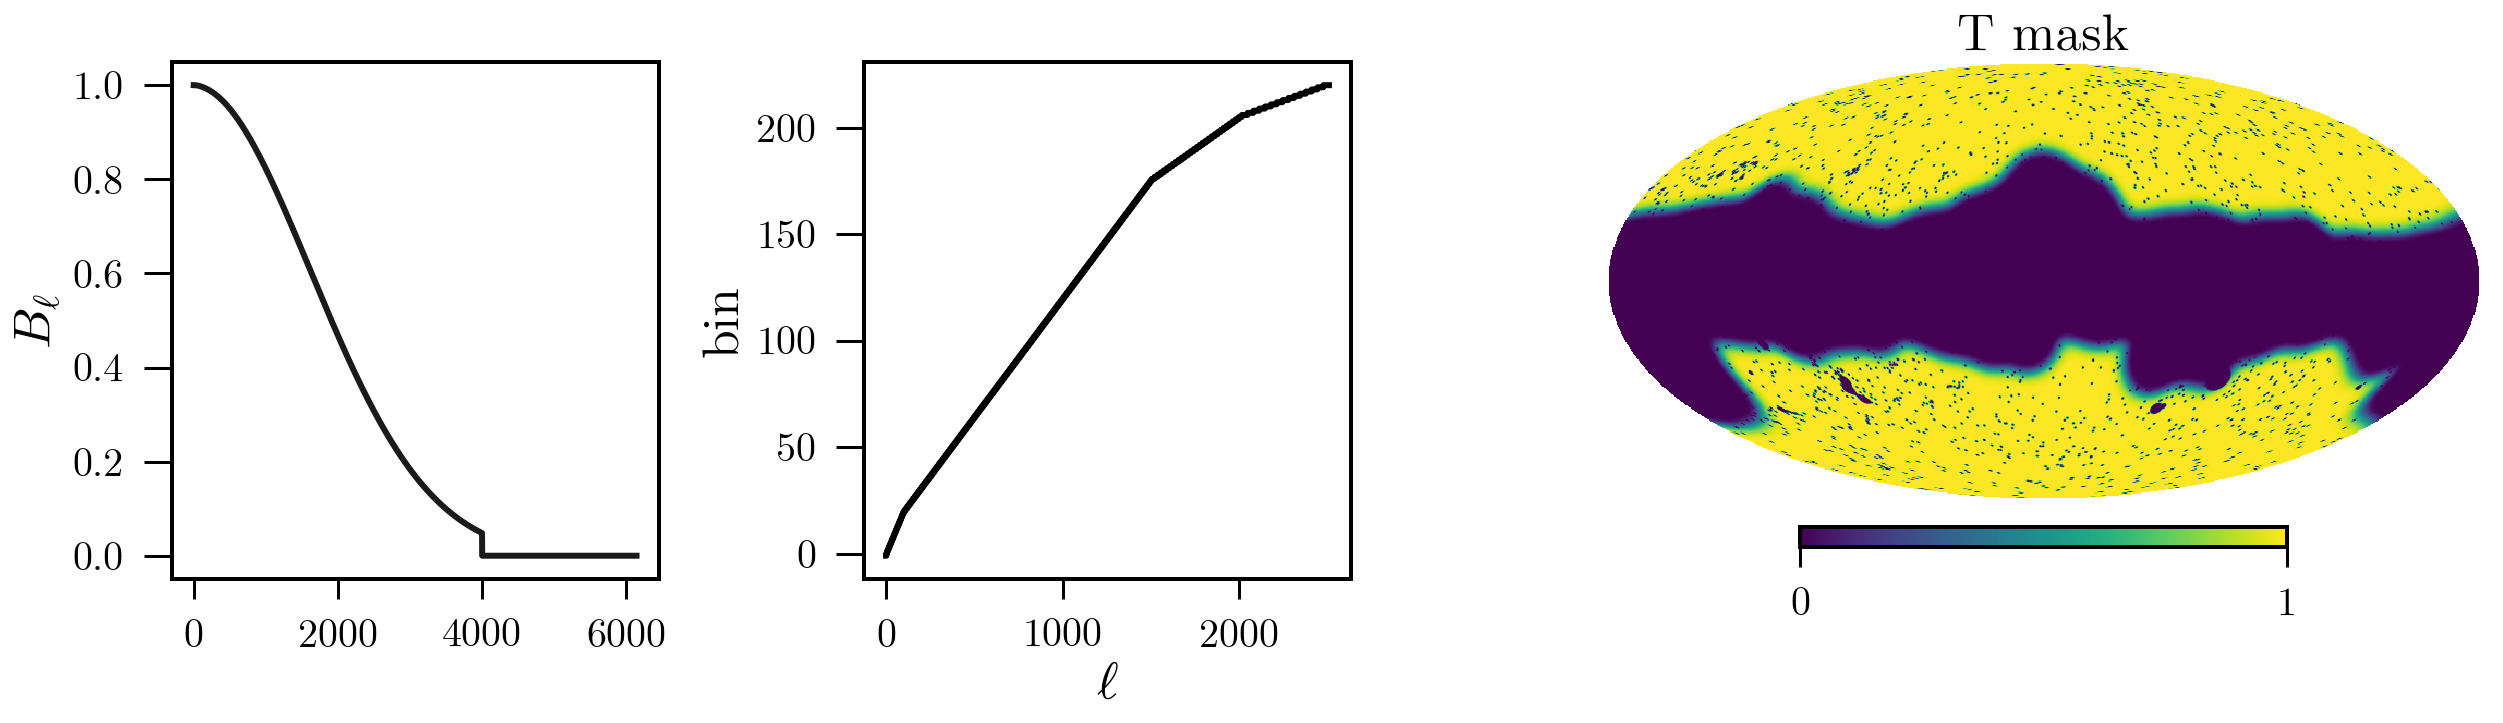

In [3]:
cl_obj = PlanckSpectrumT(f0='217', f1='217', debug=True)

In [4]:
ell, cl = cl_obj.get_spec()

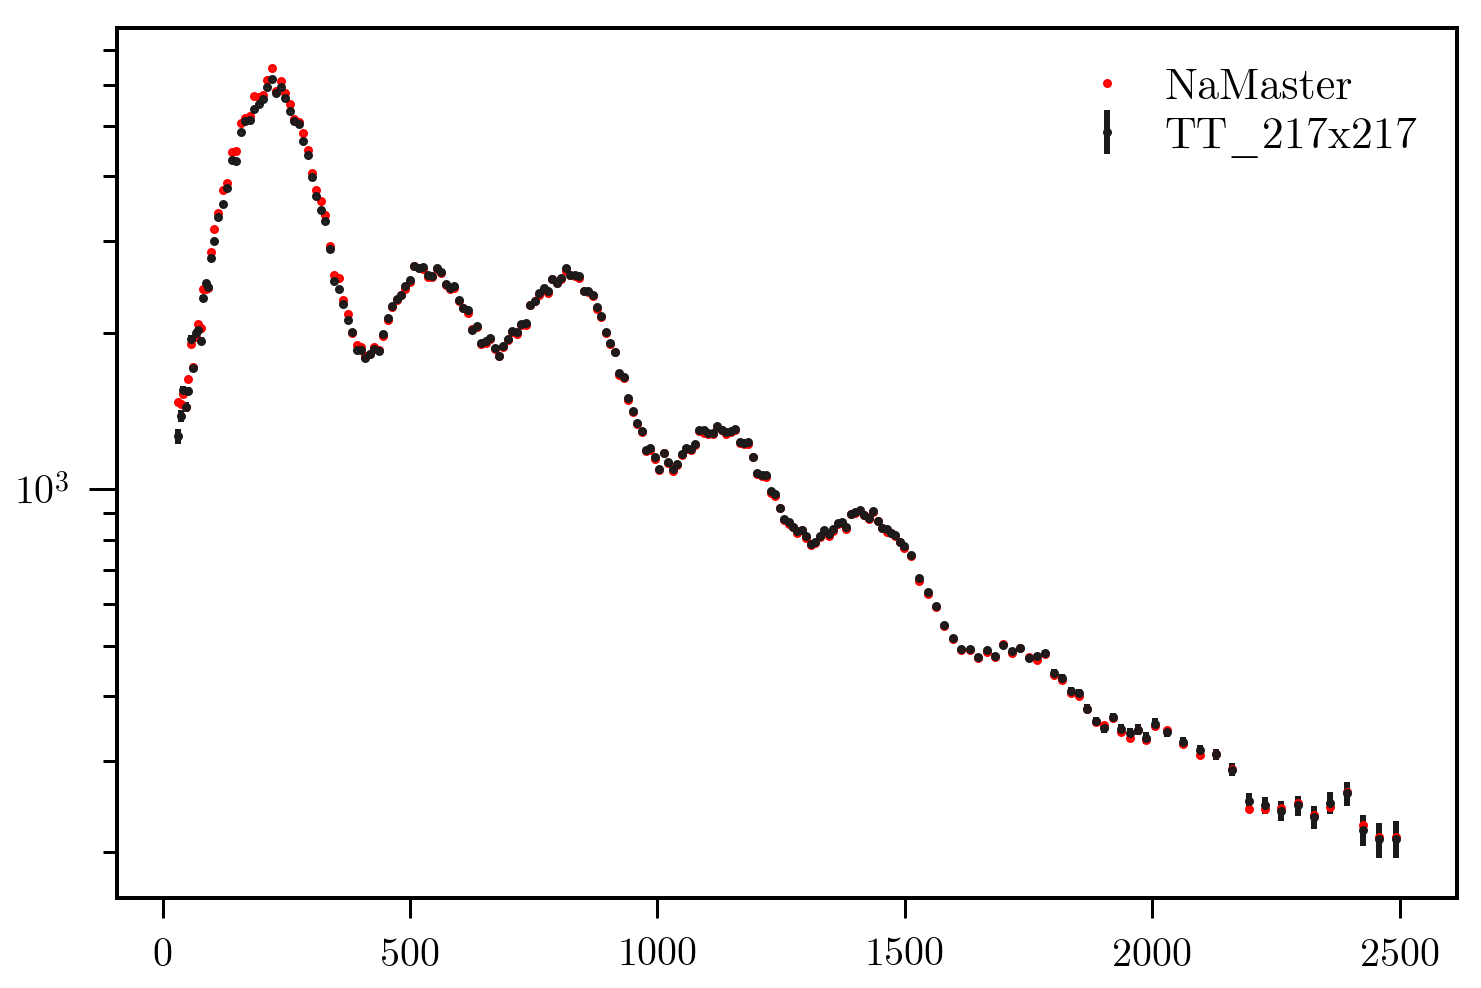

In [5]:
lmin_,lmax_,l_ref,cl_ref,error=np.loadtxt('planck_spectra/spectra_'
                                          + f'TT_{cl_obj.f0}x{cl_obj.f1}' + '.dat',unpack=True)
dl_error = error*l_ref*(l_ref+1)/(2*np.pi)
l_dl = ell[6:199+6]
dl = np.interp(x=l_ref, xp=ell, fp=cl*1e12) *l_ref*(l_ref+1)/(2*np.pi)
dl_ref = cl_ref*l_ref*(l_ref+1)/(2*np.pi)

plt.figure(figsize=(12,8))
plt.errorbar(l_ref,dl_ref,error*l_ref*(l_ref+1)/(2*np.pi),fmt='.',label=f'TT_{cl_obj.f0}x{cl_obj.f1}')
plt.plot(l_ref, dl,'r.',label=r"NaMaster")

plt.legend()
plt.yscale('log')

Text(0, 0.5, '$(D_{\\ell} - D_{\\ell}^{\\mathrm{ref}}) / \\sigma_{D\\ell}$')

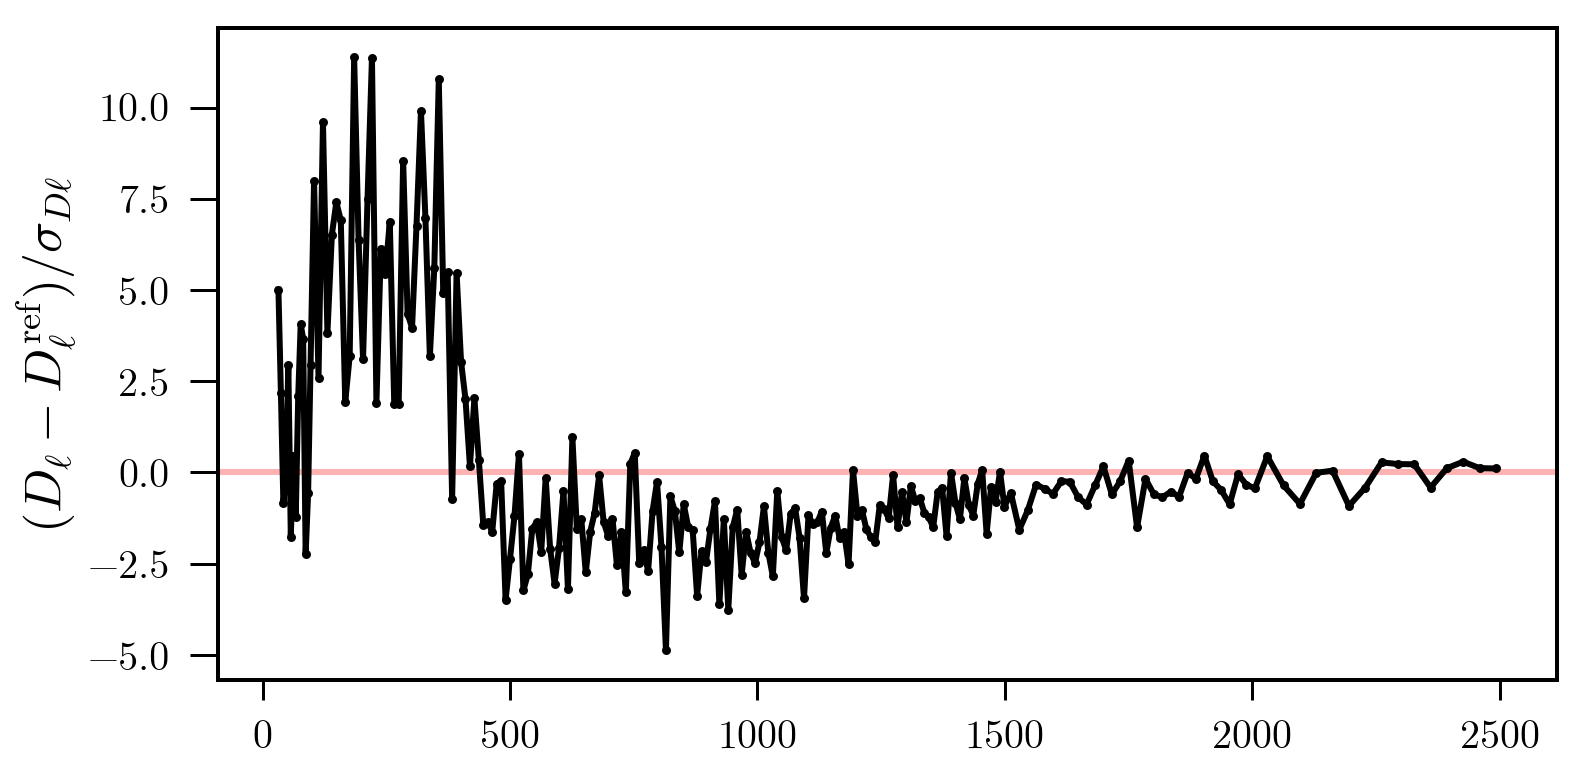

In [6]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.plot( l_ref,(dl - dl_ref) / (dl_error), 'k.-')
plt.ylabel(r'$(D_{\ell} - D_{\ell}^{\mathrm{ref}}) / \sigma_{D\ell}$')
# plt.ylim(0.98,1.02)

In [7]:
ell_dict = {}
cl_dict = {}
for l_min in [2, 15, 30]:
    ell_dict[str(l_min)], cl_dict[str(l_min)] = cl_obj.get_spec(l_min=l_min)

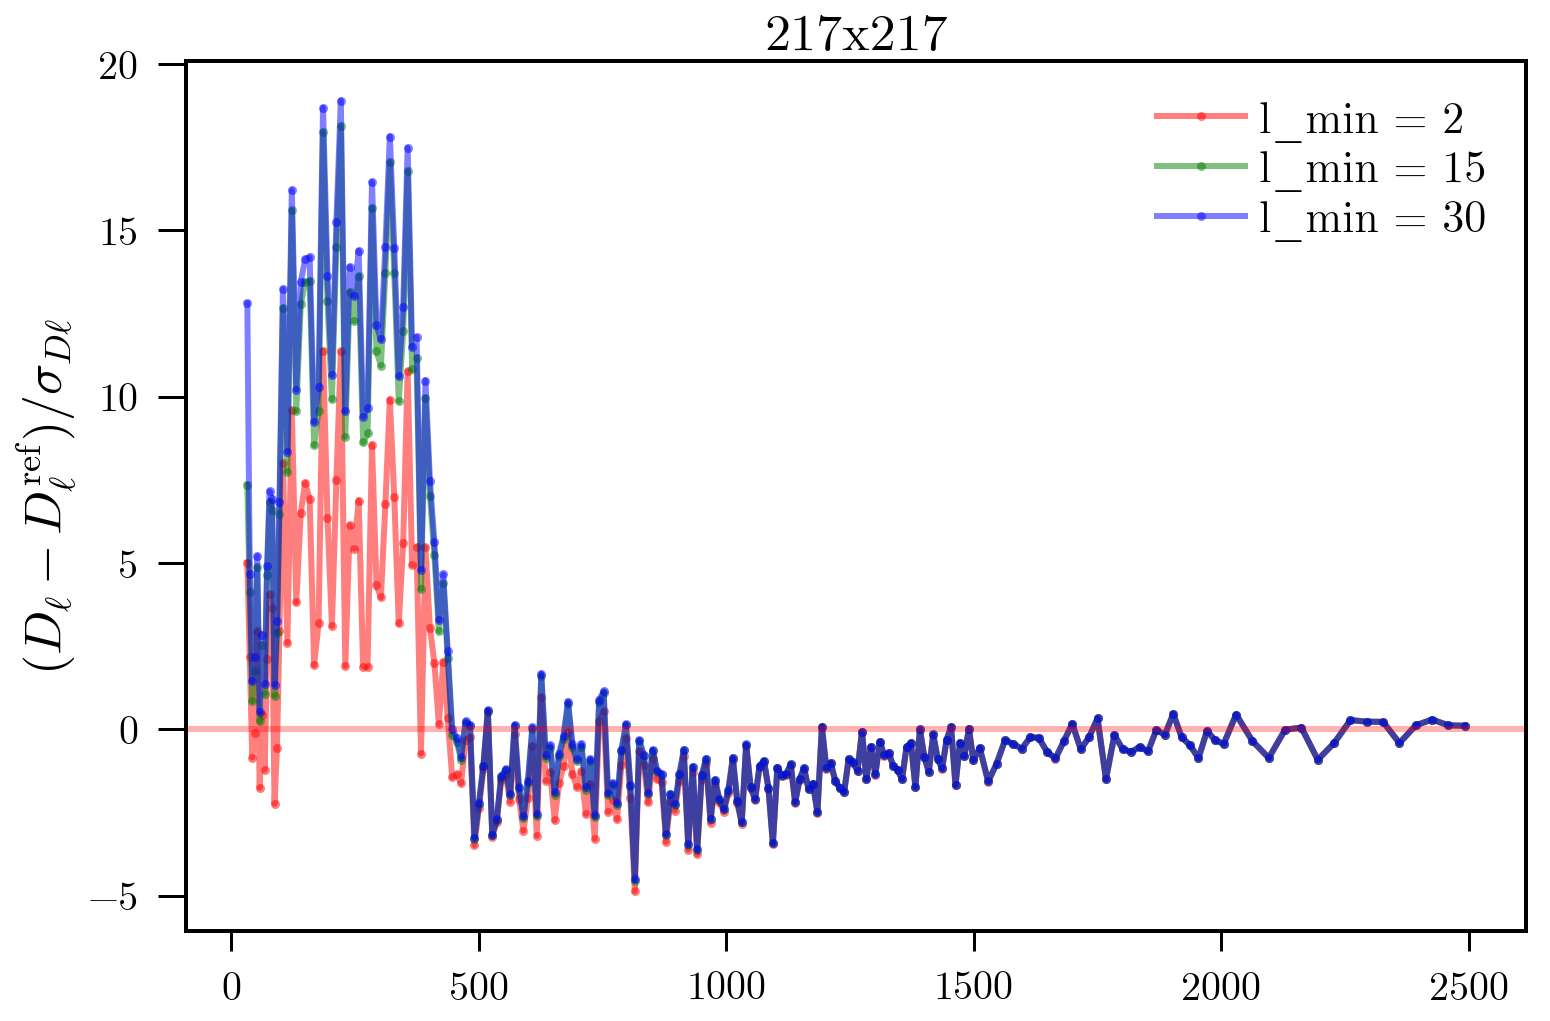

In [8]:
plt.figure(figsize=(12,8))
plt.title('217x217')
for l_min, color in zip([2, 15, 30], ['r','g','b']):
    ell, cl = ell_dict[str(l_min)], cl_dict[str(l_min)]
    dl_error = error*l_ref*(l_ref+1)/(2*np.pi)
    l_dl = ell[6:199+6]
    dl = np.interp(x=l_ref, xp=ell, fp=cl*1e12) *l_ref*(l_ref+1)/(2*np.pi)
    dl_ref = cl_ref*l_ref*(l_ref+1)/(2*np.pi)
    plt.plot( l_ref,(dl - dl_ref) / (dl_error), '.-', c=color,alpha=0.5, label=f'l_min = {l_min}')
    
plt.axhline(0, color='red', alpha=0.3)
plt.ylabel(r'$(D_{\ell} - D_{\ell}^{\mathrm{ref}}) / \sigma_{D\ell}$')
plt.legend()

# USELESS

# Test 2: PS from CMB-only Maps

Maybe it's our power spectrum code? Let's use the cleaned component-separated Commander maps. The wiki says they've been rebeamed to 5 arcminutes.

In [ ]:
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander-field-Int_2048_R2.01_halfmission-1.fits -nc --directory-prefix=testing
! wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander-field-Int_2048_R2.01_halfmission-2.fits -nc --directory-prefix=testing

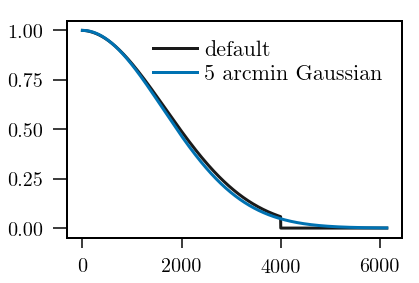

In [249]:
beam_5arcmin = hp.sphtfunc.gauss_beam(5.0 / 60.0  * np.pi / 180, lmax=lmax_beam-1)
plt.plot(default_Bl, label='default')
plt.plot(beam_5arcmin, label='5 arcmin Gaussian')
plt.legend()

In [265]:
mask = hp.read_map('masks/COM_Mask_Likelihood-temperature-217_2048_R2.00.fits', verbose=False)
map1 = hp.read_map('testing/COM_CMB_IQU-commander-field-Int_2048_R2.01_halfmission-1.fits', field=0, verbose=False)
map2 = hp.read_map('testing/COM_CMB_IQU-commander-field-Int_2048_R2.01_halfmission-2.fits', field=0, verbose=False)

badpix1 = np.logical_or(map1 < -1e30, map1 > 0.002) 
badpix2 = np.logical_or(map2 < -1e30, map2 > 0.002) 
map1[badpix1] = 0
map2[badpix2] = 0

# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask,[map1], beam=(beam_5arcmin*pixel_window), n_iter=0)
i1 = nmt.NmtField(mask,[map2], beam=(beam_5arcmin*pixel_window), n_iter=0)
dl_nmt_test2 = nmt.compute_full_master(i0,i1,db)[0] # USING db, i.e. D_ell WEIGHT
lb = b.get_effective_ells()

# must trim low ells off for comparison
lb_nmt_test2 = lb[len(bonus_left):]
dl_nmt_test2 = dl_nmt_test2[len(bonus_left):] * 1e12

Text(0, 0.5, '$D_{\\ell}^{TT,\\mathrm{Commander}} - D_{\\ell}^{TT,\\mathrm{CMB}}$')

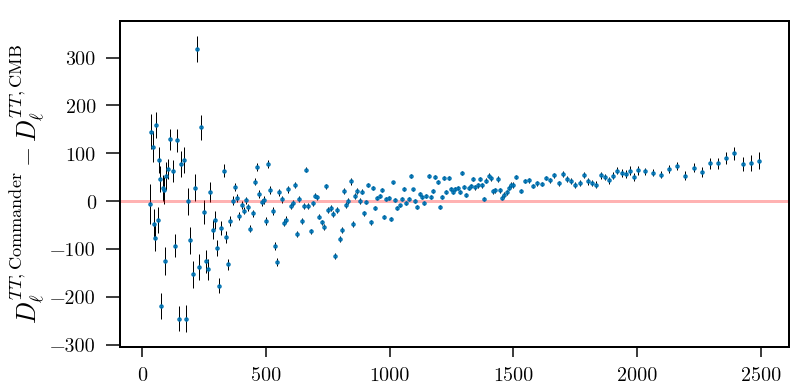

In [290]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
plt.errorbar( lb_nmt_test2, (dl_nmt_test2 * calib - dl_cmb_bestfit), 
         fmt='.', yerr=error_ref * ref_fac, elinewidth=1, color='#0072B2', ecolor='k')
plt.ylabel(r'$D_{\ell}^{TT,\mathrm{Commander}} - D_{\ell}^{TT,\mathrm{CMB}}$')


Really not sure what this tells us. I don't think I've used this correctly.